# Montar tu propio clúster

En este notebook, se detallarán todos los pasos a seguir para montar tus clústers con máquinas virtuales para Apache Hadoop.


Una vez instalado Apache Hadoop y Java, y configurar todas las variables de entorno, es necesario configurar 4 ficheros para la estructura de Apache Hadoop:

1. Core --> Contiene las propiedades y configuración general del clúster
2. HDFS --> Contiene la configuración del almacenamiento de los datos
3. MapReduce --> Configura la forma de utilizar MapReduce
4. YARN --> Configura el modo de procesamiento de datos

Para buscar estos 4 ficheros, es necesario ubicarse con el terminal el siguiente directorio:

**/opt/hadoop/etc/hadoop**

### core-site.xml

Dentro del fichero core-site.xml, es necesario rellenar una configuración:

<configuration>
	<property>
		<name>fs.defaultFS</name>
		<value>hdfs://nodo1:9000</value>
	</property>
</configuration>

Es muy importante rellenar los campos name y value de las propiedades. Name indica el nombre del sistema de ficheros, indicamos el por defecto. En value, es necesarui indicarle el maestro del clúster, en mi caso lo he llamado nodo1 y por el puerto 9000.


### hdfs-site.xml

Al igual que en el anterior, es necesario configurar este fichero.

En la primera propiedad se indica la cantidad de réplicas que se realiza a los datos que entran en el sistema de ficheros. Esto sirve para tener tolerancia a fallos, ya que si falla, se utiliza su réplica para sustituirlo.
En la segunda propiedad, se indica dónde guardar los metadatos, en este caso en máster (namenode).
En la tercera propiedad, se indica dónde se guardarán los datos, en este caso, en los nodos esclavos.

En caso de haber más nodos esclavos, será necesario indicar más propiedades de esclavos.

<configuration>
	<property>
		<name>dfs.replication</name>
		<value>1</value>
	</property>
	<property>
		<name>dfs.namenode.name.dir</name>
		<value>/datos/namenode</value>
	</property>
	<property>
		<name>dfs.datanode.data.dir</name>
		<value>/datos/datanode</value>
	</property>
</configuration>

**Es necesario crear los directorios de namenode y datanode para indicar dónde se encuentran los nodos**
mkdir /data/namenode
mkdir /data/datanode

Cuando se arranque el clúster, se guardarán todos los datos en esas carpetas de forma automática.

### mapred-site.xml

En esta configuración se indica el motor que gestiona el sistema de ficheros, en este caso el framework que se utilizará es YARN.

<property>
    <name>mapreduce.framework.name</name>
    <value>yarn</value>
</property>

### yarn-site.xml

<property>
    <name>yarn.resourcemanager.hostname</name>
    <value>nodo1</value>
</property>
<property>
    <name>yarn.nodemanager.aux-services</name>
    <value>mapreduce_shuffle</value>
</property>
<property>
    <name>yarn.nodemanager.aux-services
    .mapreduce_shuffle.class</name>
    <value>org.apache.hadoop.mapred.ShuffleHandler</value>
</property>

En la primera propiedad se indica el quién es el resource manager.
En las siguientes propiedades indican las clases que utilizan.

Tras arrancar YARN, es posible visualizar con una interfaz html, toda la estructura del YARN:

**http://nodo1:8088/**



### Clúster Pseudodistribuido

Para esta sección, como únicamente hay 1 nodo, solo es necesario configurar estos dos ficheros.

Para arranzar el HDFS, es necesario ubicarse en el siguiente directorio:
**/opt/hadoop/sbin**

En esta carpeta contiene diferentes servicios ejecutables, por ejemplo arrancar HDFS.
**start-dfs.sh**
De forma automática, llamará y realizará todas las operaciones indicadas en las configuraciones.

**EXTRA: Con el comando jps, se puede ver los procesos java que se están ejecutando**

Tras arrancar HDFS, es posible visualizar con una interfaz html, toda la estructura del clúster:

**http://nodo1:9870/**

Para la interacción segura entre maestro y esclavos, es necesario configurar SSH con claves públicas y privadas. (Ver Vídeo 24)



### Cómo funciona los metadatos de HDFS

Cuando se arranca HDFS con start-dfs.sh, dentro del directorio namenode (maestro) suceden varios procesos que monitorizan todos los almacenamientos que suceden dentro de HDFS.

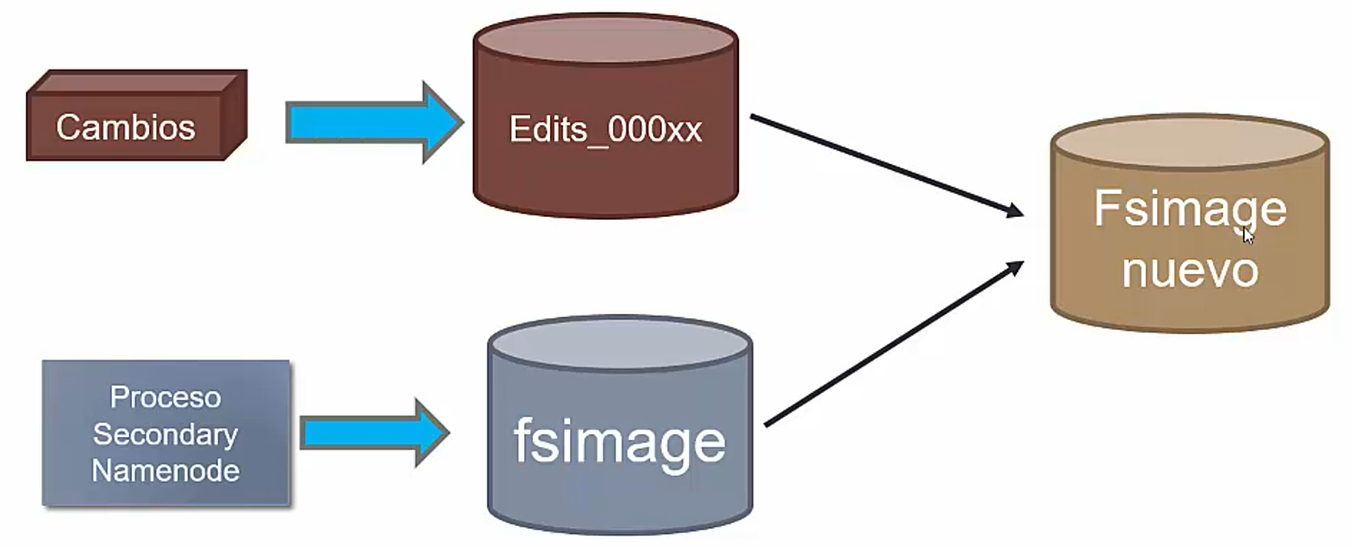

Para el almacenamiento de los metadatos de HDFS, consta de 3 partes:

#### fsimage

Esta imagen guarda el estado completo del último checkpoint de todo el sistema de ficheros, actualizado por el Secondary Namenode. En el momento que se arranca HDFS, recoge el último fsimage para recuperar todos los metadatos que se almacenaron. Todos los metadatos se guardan en los ficheros edits.

#### Edits

Son los cambios que se van produciendo en la Base de datos de HDFS.

#### Edits_inProgress

Todos los cambios que se están realizando en directo dentro de la memoria.

El proceso de principio a fin es el siguiente:

Supongamos que vamos a almacenando cambios, que se guardarán en los ficheros edits. Cada cierto tiempo, el proceso Secondary Namenode recoge el fsimage y todos los edits para generar un nuevo fsimage. 



# Clúster Real

Para montar un clúster real, es necesario primero clonar y configurar las máquinas virtuales para usarlos como nodos esclavos.

1. Para ello, clonaremos la MV, llamándolos nodo2 y nodo2, con las direcciones MAC diferentes y una clonación completa, no enlazada.

2. También habilitaremos una red interna, llamándolo eth0 o intnet.

3. Ejecutamos las 3 máquinas y configuramos las 3 ips --> 192.168.0.101...102...103

4. Comprobamos con ping para realizar un mensaje ICMP y ver que se pueden comunicar entre las máquinas.

Luego configuramos las conexiones ssh entre las máquinas para una conexión más segura.

Tocamos los ficheros Hostname y Hosts para indicar los nombres de los nodos y el nombre del usuario.

Finalmente, configuramos los ficheros hdfs-site.xml, yarn-site.xml y Workers para indicar que el namenode no va a ser él mismo (por la configuración del clúster pseudodistribuido) y conectar los ndoos esclavos nodo2 y nodo3.

Muy importante tener en cuenta deshabilitar el firewall o al menos abrir todos los puertos para estos IPs para que las reglas Iptables no bloqueen las conexiones para crear el clúster.



# Hive

Es posible configurar la herramienta de Hive para crear tablas y distribuir los datos dentro de HDFS.

Para ello se deben configurar varios archivos:

1. Lo primero de todo, es necesario crear dos carpetas dentro de HDFS y darle permisos: 
  <ul>
  <li>hdfs dfs -mkdir /tmp</li>
  <li>hdfs dfs -chmod g+w /tmp</li>
  <li>hdfs dfs -mkdir -p /user/hive/warehouse</li>
  <li>hdfs dfs -chmod g+w /user/hive/warehouse</li>
  </ul>
  
  
2. Ahora instalar del .tar de Hive que hay que descargar en la página oficial y situarlo dentro de /opt/hadoop.

3. En el .bashrc, añadir en la variable de entorno $HIVE_HOME=/opt/hadoop/hive y agregarlo al PATH

4. Entrar en el directorio conf de Hive y eliminar el nombre .template de todos los archivos.

5. Cambiar la configuración de Hive en el archivo hive-site.xml lo que indique el vídeo 081.

6. Ejecutar el siguiente comando: tool -dbType derby -initSchema

# Spark

Para utilizar Spark dentro del entorno creado durante el curso, necesitaremos descargarnos Spark dentro de la página oficial sin Hadoop integrado.

1. Es necesario entrar en la página oficial de Spark y descargar una version "Pre-build with user-provided Apache Hadoop" para indicar que ya tenemos el entorno de Apache Hadoop montado y únicamente necesitamos Spark.

2. Una vez descargado el tar, descomprimirlo y situarlo en /opt/hadoop, como en Hive.

3. Congifurar .bashrc para añadir las variables de entorno SPARK_DIST_CLASSPATH y añadir /sbin y /bin en el PATH.

 3.1 Si SPARK_DIST_CLASSPATH falla, es necesario especificar manualmente todas las dependencias, en vez de utilizar $(hadoop classpath)
